# TABLE OF CONTENTS 

1. Amazon Stock-Data Pipeline



2. Data Analysis 

      2.1 Data Exploration Analysis
      
      2.2 Data Exploration Analysis-Outlier Detection & Distribution
      
      
      
3. Feature Engineering

      3.1 Historical stock price movements  
      
      3.2 Amazon Stock Perfomance
      
      3.3 Stock Market indicators (RSI)
      
      3.4 Volume of trades
      
      3.5 Stock prices moving average
      
      3.6 Pairplot :Establish relationships,patterns and correlation
      
      
      
4. Data Pre-processing 

      4.1 Dropping outlier data/unrelated data(improve model perfomance)
      
      4.2 Data Normalisation
      
      
      
5. Data Modelling 

      5.1 Data Modelling-Keras (time series)
      
      5.2 Model prediction
      
      5.3 Model Optimization
      
      
      
6. Model Summary 

      6.1 Model outcome
      
      6.2 Project Summary/Conclusion


In [ ]:
import yfinance as yahoo_finance
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from ta.momentum import RSIIndicator

# 1.AMAZON STOCK DATA PIPELINE 

Amazon stock prices data would be fecthed directly from the yahoo finance 

Data fecthed would mantain a 10 year period,from 10 years ago until now.

All the variables(Open, High, Low, and Close prices) are auto_adjusted, By adjusting the historical prices for dividends and splits, it computes a scaling factor that is the ratio of the adjusted close price to the unadjusted close price. 

This adjustment is beneficial because dividends and stock splits can have a substantial impact on stock prices, and factoring them in can result in a more precise representation of the stock price movements over time.

In [ ]:
ticker = 'AMZN'
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=3652)).strftime('%Y-%m-%d')

def fetch_AMZN_data():
    AMZN_stock_data = yahoo_finance.download(ticker, start_date, end_date, interval='1d',
                                         auto_adjust=True)[['Open', 'High', 'Low', 'Close', 'Volume']]
    return pd.DataFrame(AMZN_stock_data)

AMZN_data = fetch_AMZN_data()


[*********************100%***********************]  1 of 1 completed


In [ ]:
AMZN_data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2013-04-05,12.7860,12.8090,12.6835,12.7740,51148000
2013-04-08,12.7960,12.9840,12.7815,12.9475,45912000
2013-04-09,12.9425,13.1305,12.8500,13.0570,43132000
2013-04-10,13.0890,13.2990,12.9660,13.2385,46450000
2013-04-11,13.2370,13.5485,13.2370,13.4925,61810000


AMZN_data["Date"] = pd.to_datetime(AMZN_data["Date"])

# 2.DATA ANALYSIS 


# 2.1 Data Exploration Analysis

In [ ]:
AMZN_data.describe()

,Open,High,Low,Close,Volume
count,2518.000000,2518.000000,2518.000000,2518.000000,2.518000e+03
mean,75.936408,76.813493,74.962773,75.903265,8.021966e+07
std,52.552994,53.202983,51.828832,52.501186,4.205689e+07
min,12.447000,12.646500,12.287500,12.411500,1.762600e+07
25%,26.736251,26.986375,26.361001,26.715000,5.373150e+07
50%,75.113998,76.386997,73.998001,75.013248,6.876000e+07
75%,108.070126,110.624376,106.313625,107.945875,9.291200e+07
max,187.199997,188.654007,184.839493,186.570496,4.771220e+08


In [ ]:
AMZN_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2013-04-05 to 2023-04-04
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2518 non-null   float64
 1   High    2518 non-null   float64
 2   Low     2518 non-null   float64
 3   Close   2518 non-null   float64
 4   Volume  2518 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 118.0 KB


In [ ]:
AMZN_data.shape

(2518, 5)

# 2.2 Data Exploration Analysis-Outlier Detection & Distribution

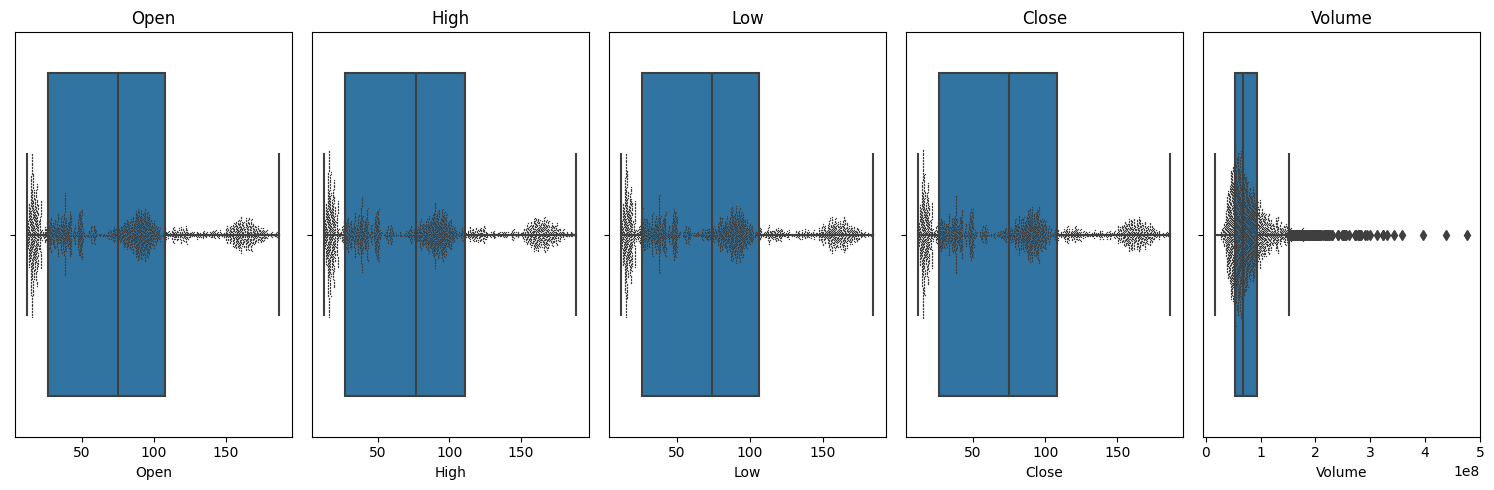

In [ ]:
features = ["Open", "High", "Low", "Close", "Volume"]
AMZN_stock= pd.DataFrame()
for feature in features:
    AMZN_stock[feature] = AMZN_data[feature]

fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(15, 5))
for i, feature in enumerate(features):
    sns.boxplot(x=AMZN_stock[feature], ax=axes[i])
    sns.swarmplot(x=AMZN_stock[feature], color=".25",s=1, ax=axes[i])
    axes[i].set_title(feature)
    
plt.tight_layout()
plt.show()


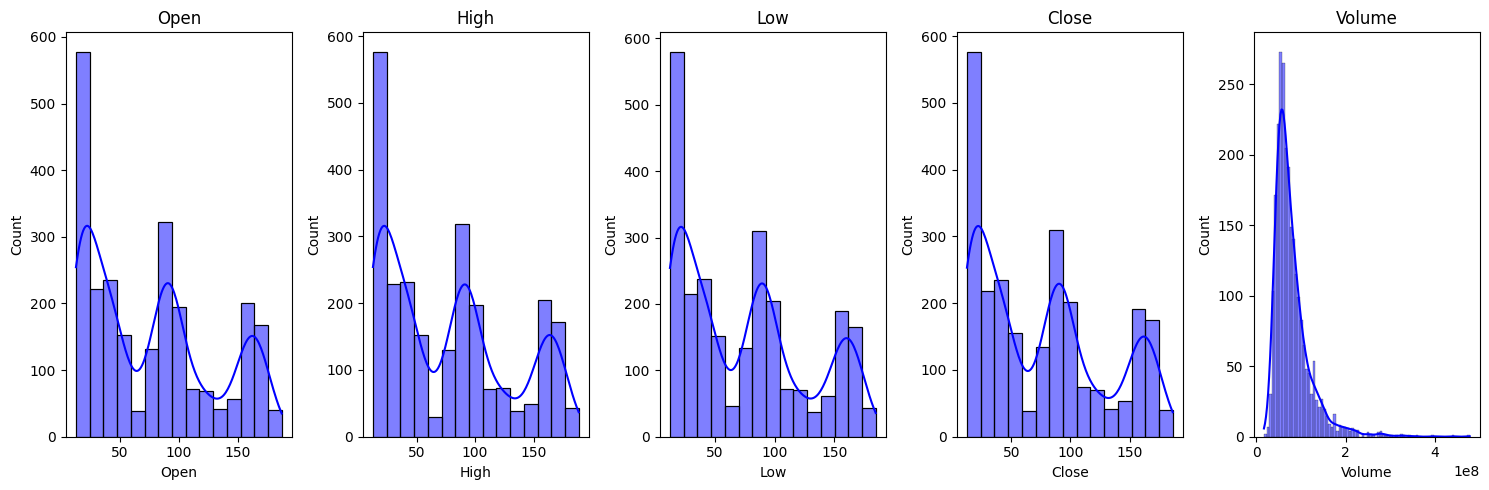

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(15,5))
for i, feature in enumerate(features):
    sns.histplot(x=AMZN_stock[feature], ax=axes[i], kde=True,color="blue")
    axes[i].set_title(feature)
    
plt.tight_layout()
plt.show()

In [ ]:
Q1 = AMZN_data['Volume'].quantile(0.25)
Q3 = AMZN_data['Volume'].quantile(0.75)
IQR = Q3 - Q1
outliers = (AMZN_data['Volume'] < Q1 - 1.5*IQR) | (AMZN_data['Volume'] > Q3 + 1.5*IQR)
volume_outliers = AMZN_data.loc[outliers, 'Volume']
print(volume_outliers.min())
print(volume_outliers.max())

151964000
477122000


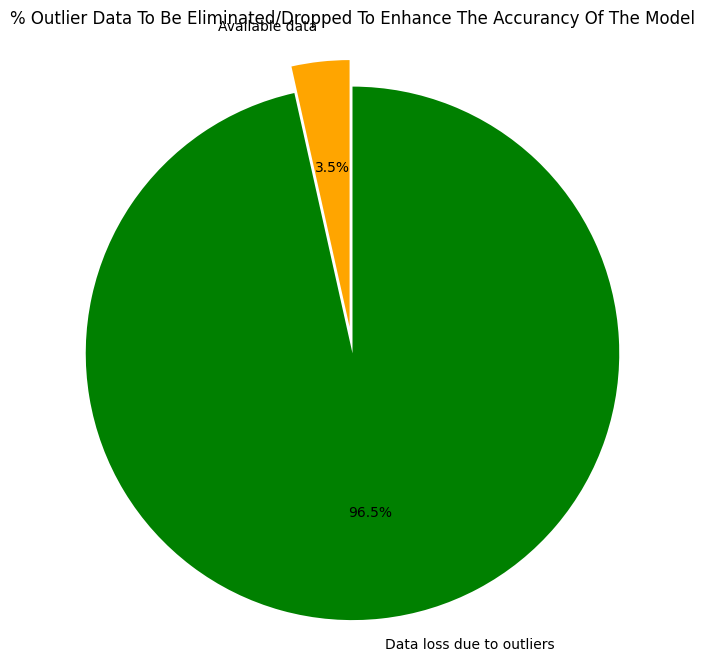

In [ ]:
# Calculate the outlier percentage
Q1 = AMZN_data.quantile(0.25)
Q3 = AMZN_data.quantile(0.75)
IQR = Q3 - Q1
AMZN_data = AMZN_data.apply(pd.to_numeric, errors='coerce')
outlier_perc = 100 * ((AMZN_data < (Q1 - 1.5 * IQR)) | (AMZN_data > (Q3 + 1.5 * IQR))).sum(axis=1) / len(AMZN_data.columns)
total_outlier_perc = outlier_perc.sum()

# Create the labels for the plot
labels = ['Available data\n', 'Data loss due to outliers']
values = [100, total_outlier_perc]
colors = ['orange', 'green']
explode = (0, 0.1,)
fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(values, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
plt.title('% Outlier Data To Be Eliminated/Dropped To Enhance The Accurancy Of The Model')
plt.show()

# 3.FEATURE ENGINEERING

# 3.1 Historical stock price movements 

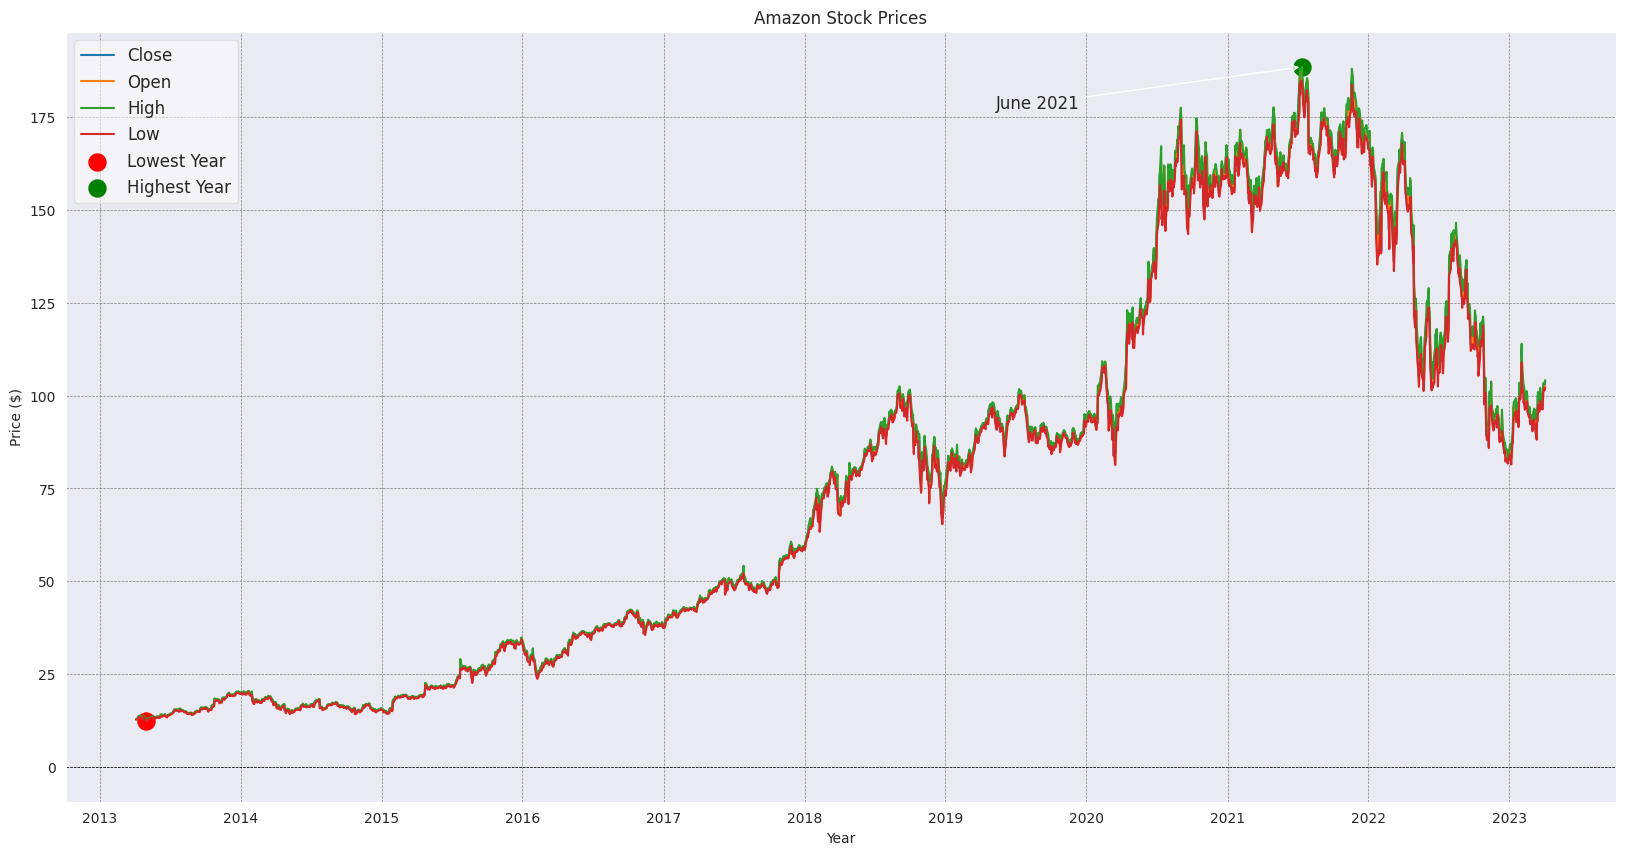

In [ ]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(AMZN_data['Close'], label='Close')
ax.plot(AMZN_data['Open'], label='Open')
ax.plot(AMZN_data['High'], label='High')
ax.plot(AMZN_data['Low'], label='Low')
low_year = AMZN_data['Low'].idxmin()
high_year = AMZN_data['High'].idxmax()
ax.scatter(low_year, AMZN_data.loc[low_year, 'Low'], s=150, color='red', label='Lowest Year')
ax.scatter(high_year, AMZN_data.loc[high_year, 'High'], s=150, color='green', label='Highest Year')
ax.set_xlabel('Year')
ax.set_ylabel('Price ($)')
ax.set_title('Amazon Stock Prices')
ax.legend(loc='upper left', frameon=True, facecolor='white', framealpha=0.5, fontsize='large')
ax.grid(color='gray', linestyle='--', linewidth=0.5)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
ax.annotate("June 2021",xy=(AMZN_data['High'].idxmax(), AMZN_data['High'].max()), xytext=(0.6, 0.9),
            textcoords='axes fraction', arrowprops=dict(facecolor='black', arrowstyle='->', connectionstyle='arc3'),
            fontsize='large')
plt.show()



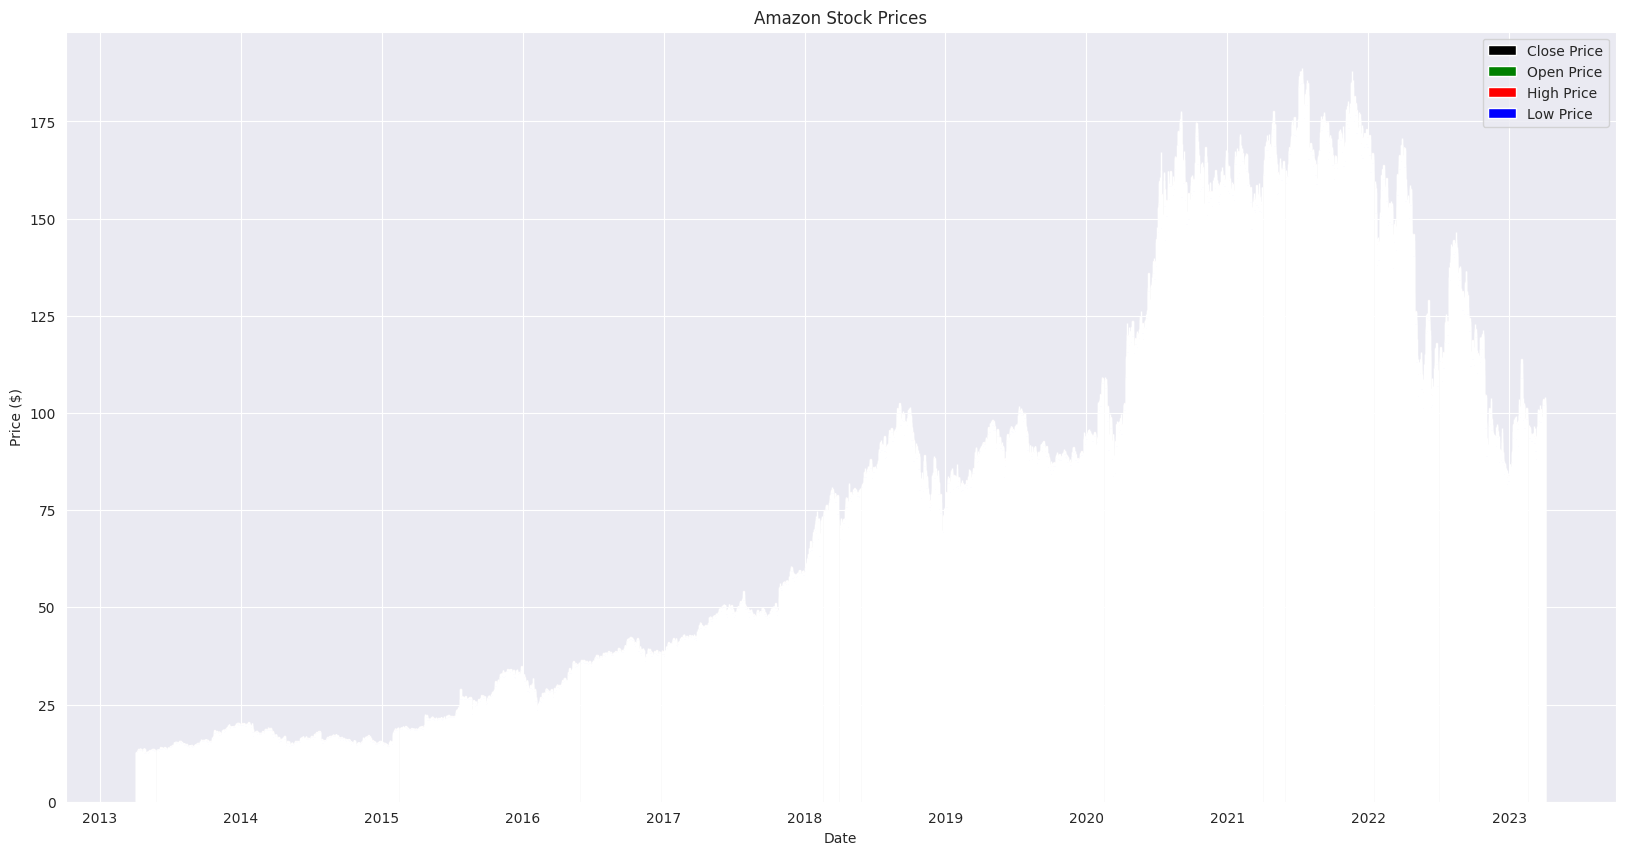

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(AMZN_data.index, AMZN_data['Close'], label='Close Price', color='black')
ax.bar(AMZN_data.index, AMZN_data['Open'], label='Open Price', color='green')
ax.bar(AMZN_data.index, AMZN_data['High'], label='High Price', color='red')
ax.bar(AMZN_data.index, AMZN_data['Low'], label='Low Price', color='blue')

ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.set_title('Amazon Stock Prices')
ax.legend(loc='best')

plt.show()

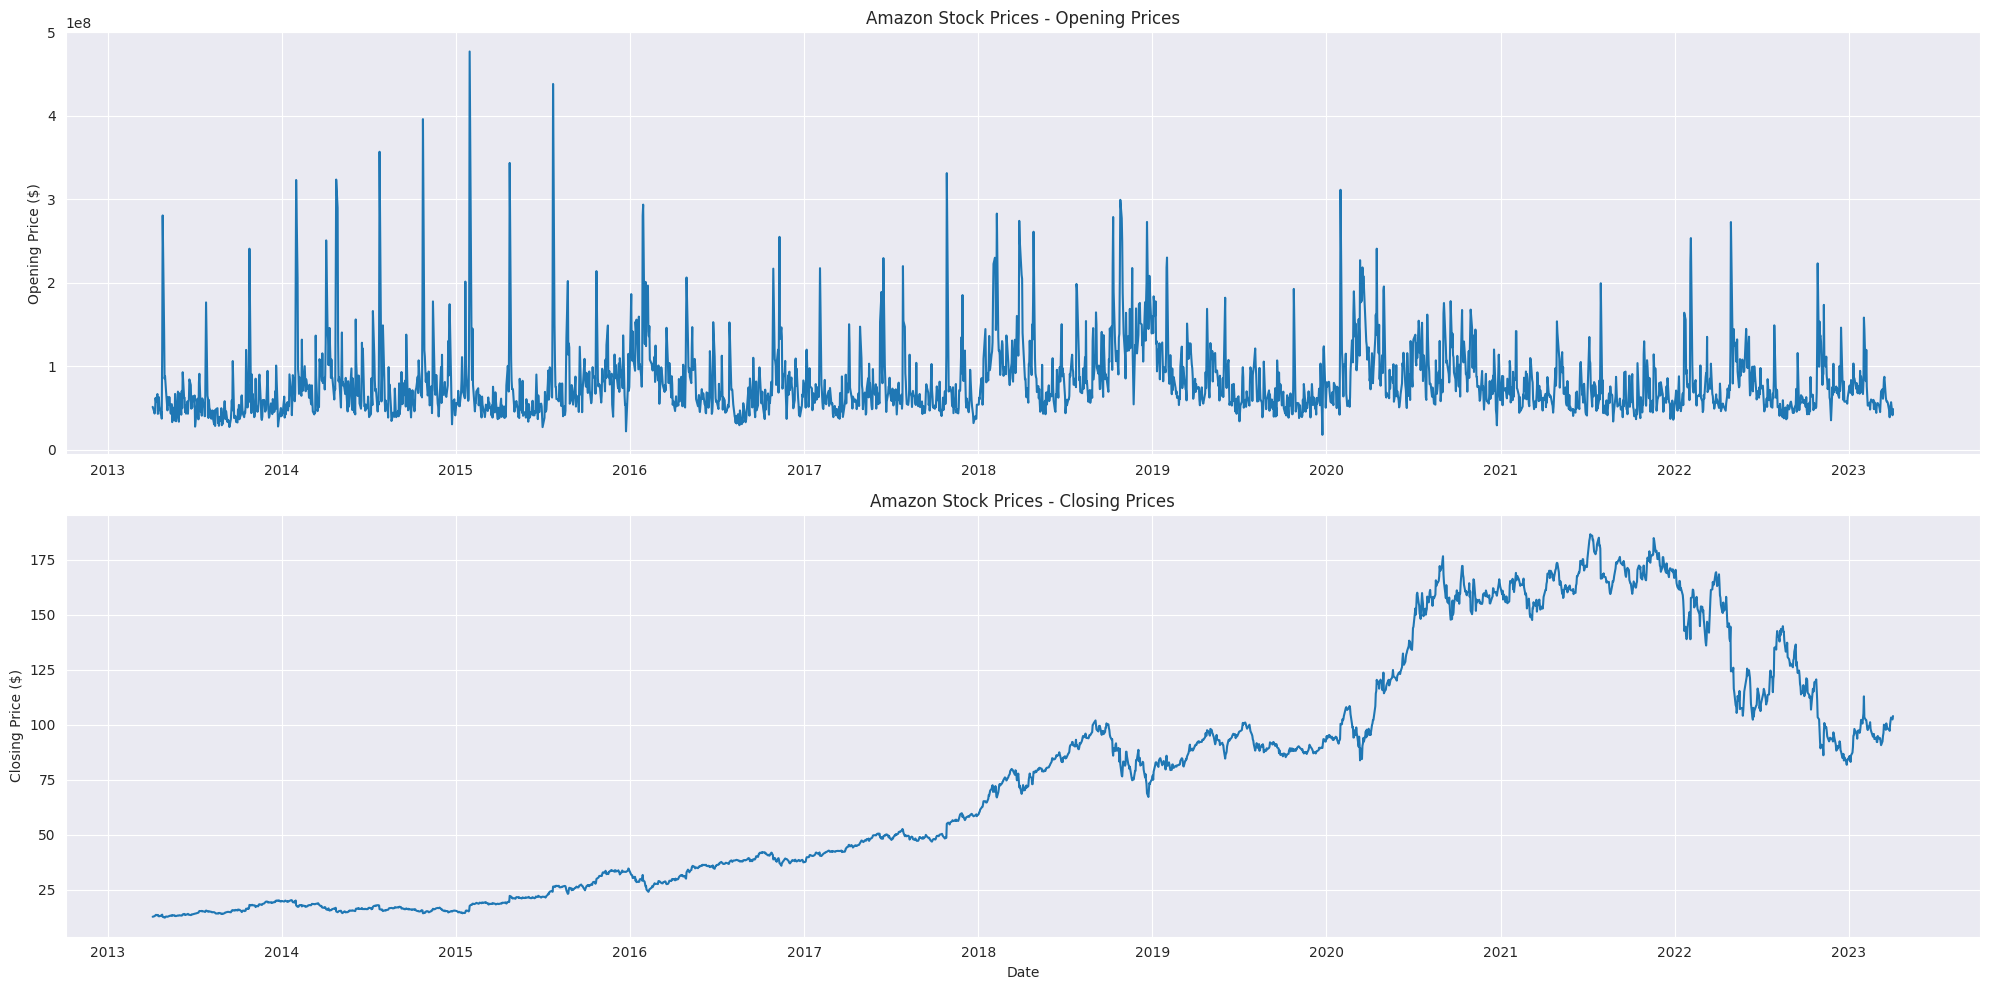

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
# plot opening prices on top subplot
axs[0].plot(AMZN_data['Open'].index, AMZN_data['Volume'])
axs[0].set_ylabel('Opening Price ($)')
axs[0].set_title('Amazon Stock Prices - Opening Prices')

# plot closing prices on bottom subplot
axs[1].plot(AMZN_data['Close'].index, AMZN_data['Close'])
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Closing Price ($)')
axs[1].set_title('Amazon Stock Prices - Closing Prices')

plt.tight_layout()
plt.show()

# 3.2 Amazon Stock Perfomance 

[*********************100%***********************]  1 of 1 completed


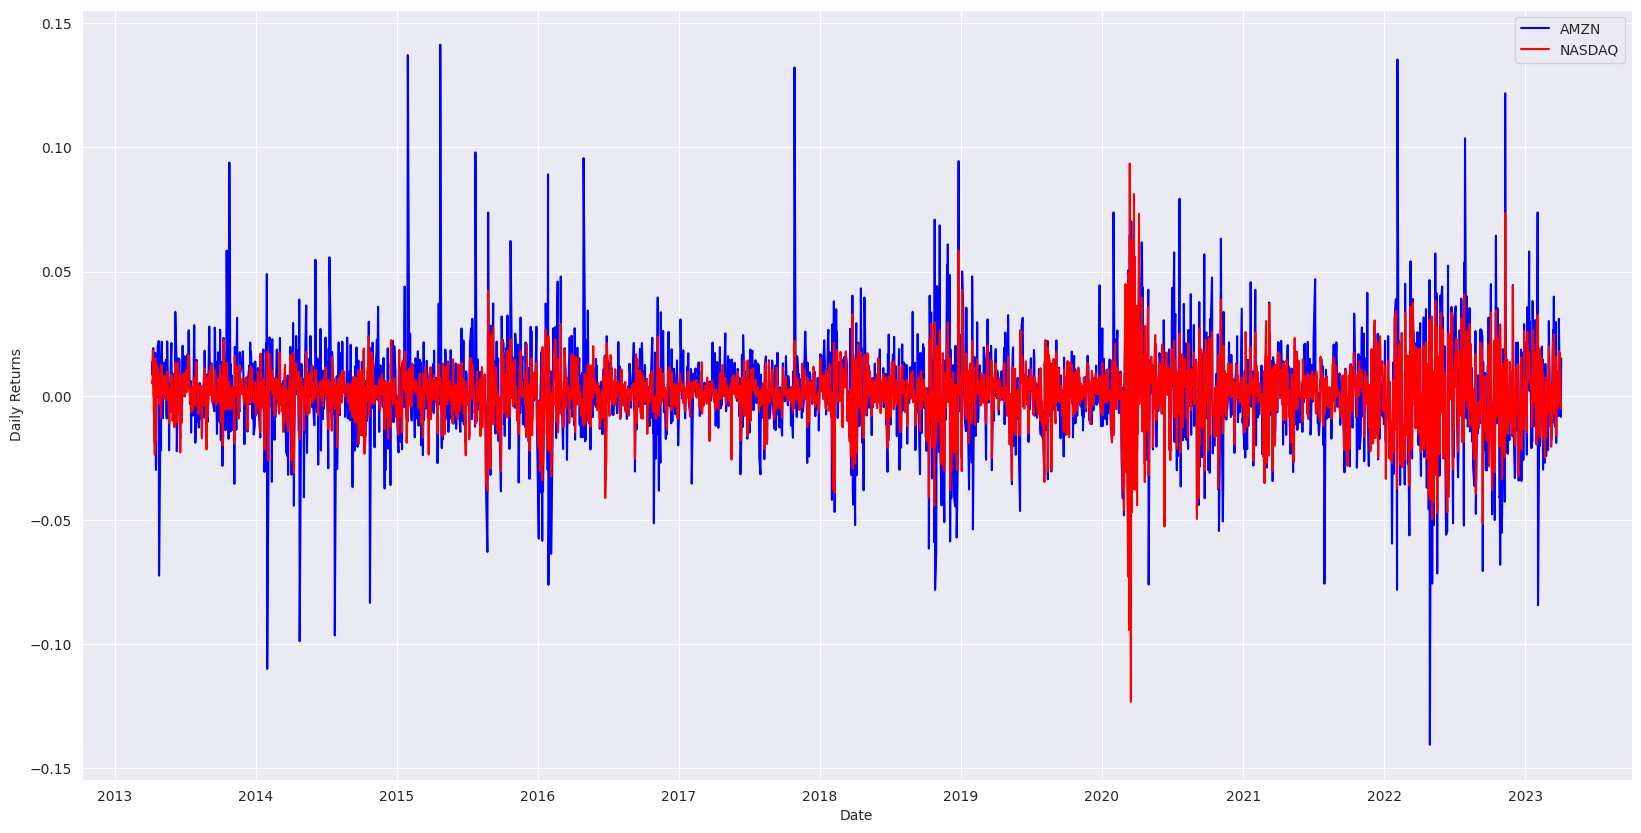

In [ ]:
# Plot the daily returns of Amazon and NASDAQ
# Market perfomance relative to S&P bench mark 
nasdaq_data = yahoo_finance.download("^IXIC",start=start_date, end=end_date)

# Calculate daily returns
Daily_returns_AMZN = AMZN_data['Close'].pct_change()
Daily_returns_nasdaq_data = nasdaq_data['Close'].pct_change()

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(Daily_returns_AMZN.index, Daily_returns_AMZN, label='AMZN',color="blue")
ax.plot(Daily_returns_nasdaq_data.index, Daily_returns_nasdaq_data, label='NASDAQ',color="red")
ax.set_xlabel('Date')
ax.set_ylabel('Daily Returns')
ax.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed


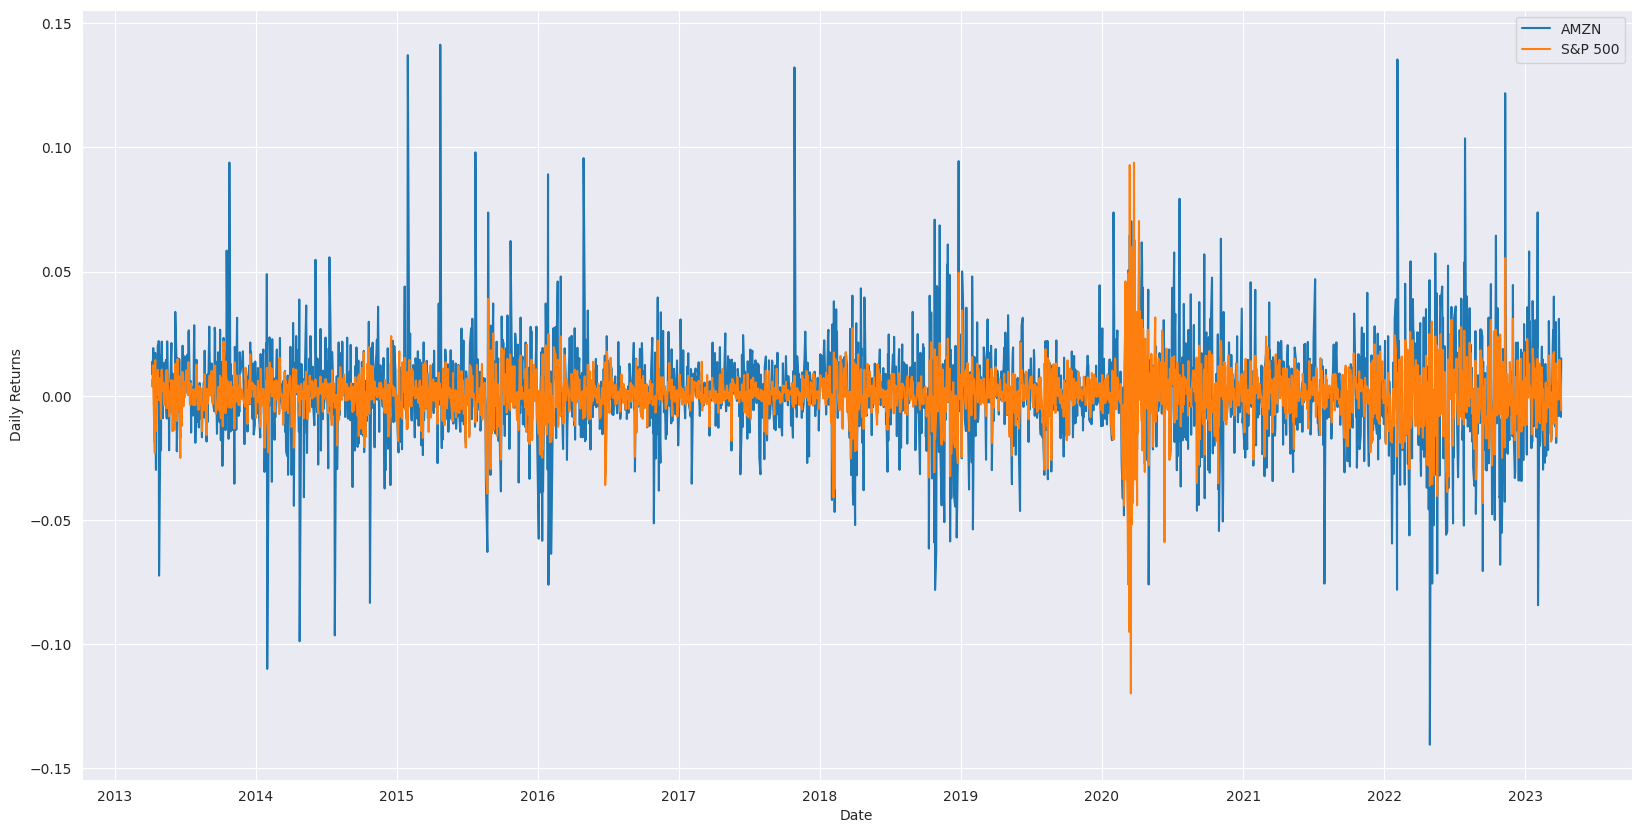

In [ ]:
#Market perfomance relative to S&P bench mark 

S_and_P = yahoo_finance.download("^GSPC", start=start_date, end=end_date)

# Calculate daily returns
Daily_returns_AMZN = AMZN_data['Close'].pct_change()
Daily_returns_SP = S_and_P['Close'].pct_change()

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(Daily_returns_AMZN .index,Daily_returns_AMZN, label='AMZN')
ax.plot(Daily_returns_SP.index,Daily_returns_SP, label='S&P 500')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Returns')
ax.legend()
plt.show()

# 3.3 Stock Market indicators (RSI)

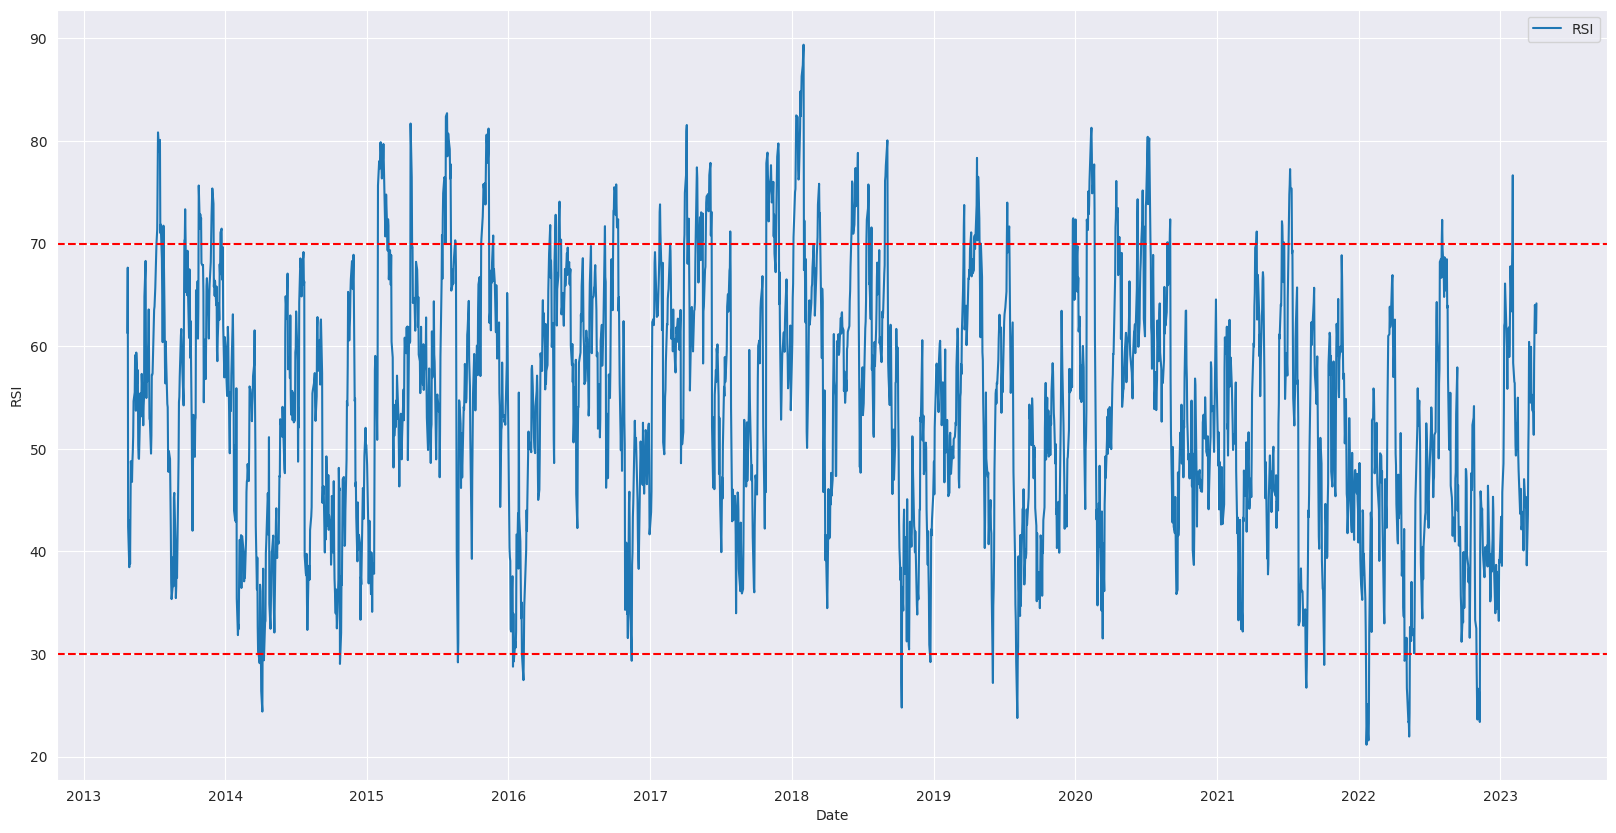

In [ ]:
# Calculate the relative strength index (RSI) using the ta library

rsi_indicator = RSIIndicator(AMZN_data['Close'], window=14)
AMZN_data['RSI'] = rsi_indicator.rsi()

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(AMZN_data.index, AMZN_data['RSI'], label='RSI')
ax.axhline(y=30, color='red', linestyle='--')
ax.axhline(y=70, color='red', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('RSI')
ax.legend()
plt.show()

# 3.4 Volume of trades 

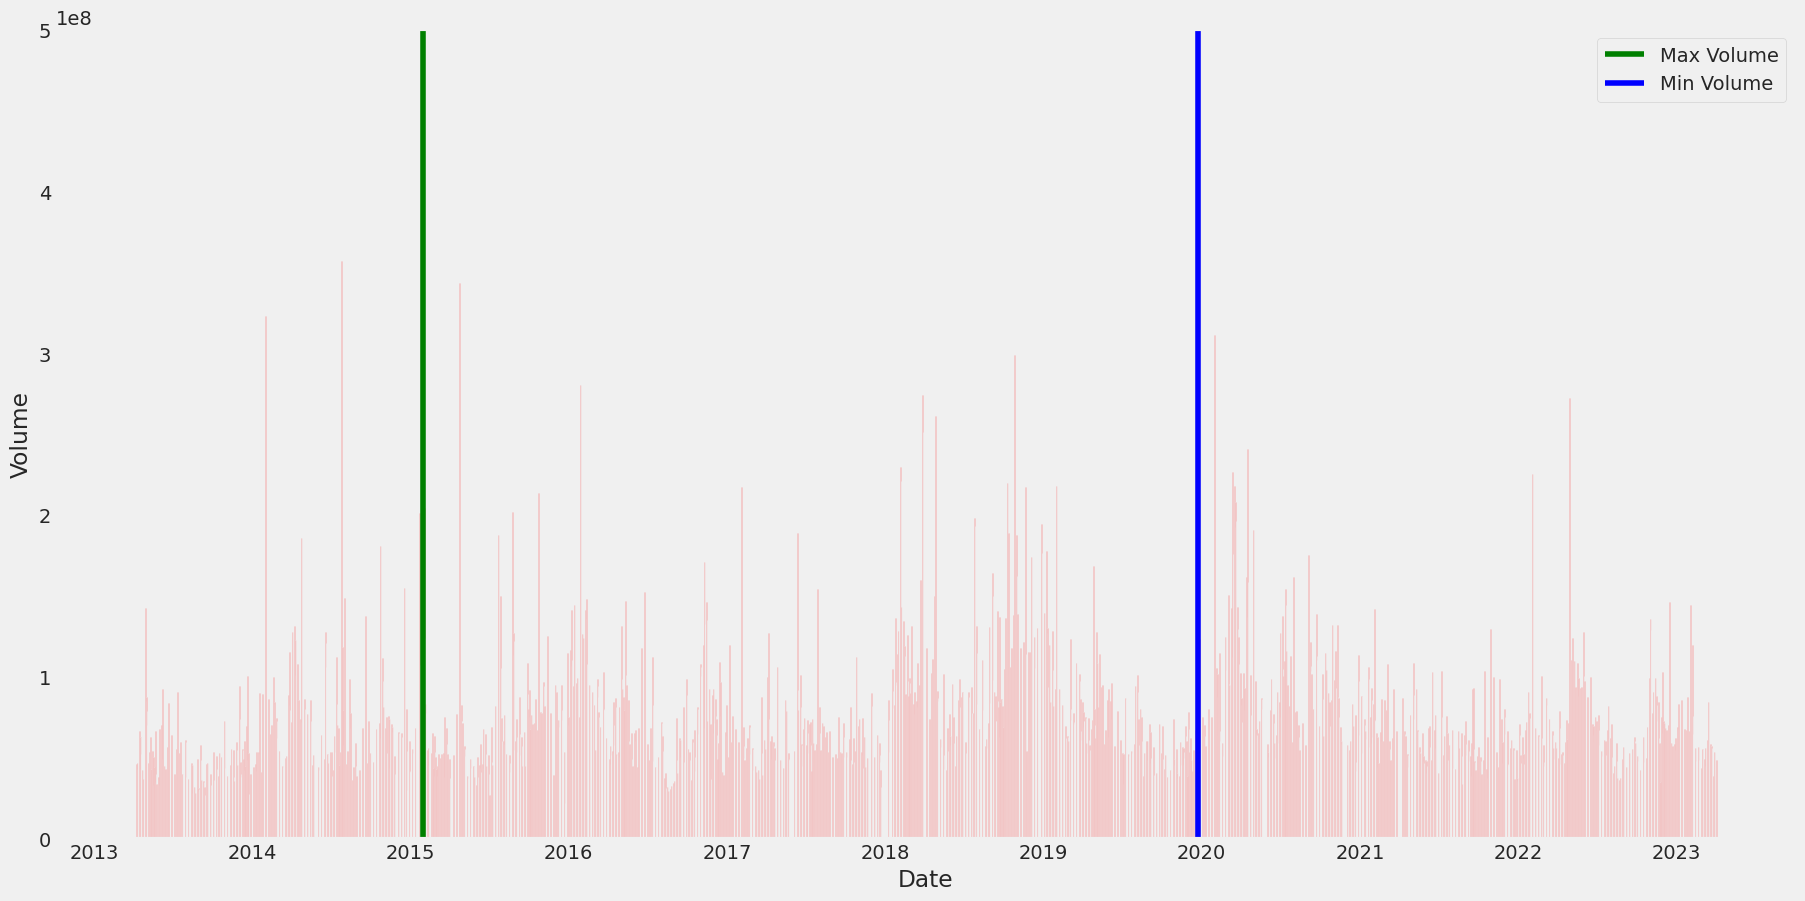

In [ ]:
max_volume_date = AMZN_data.loc[AMZN_data['Volume'].idxmax()].name
min_volume_date = AMZN_data.loc[AMZN_data['Volume'].idxmin()].name

# Plot the volume of trades using a bar chart
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(AMZN_data.index, AMZN_data['Volume'], color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Volume')
ax.axvline(x=max_volume_date, color='green', label='Max Volume')
ax.axvline(x=min_volume_date, color='blue', label='Min Volume')
ax.legend()
ax.grid(False)
plt.show()

# 3.5 Stock prices moving average 

In [ ]:
# Plot the closing prices and moving averages
moving_avg_20 = AMZN_data['Close'].rolling(window=20).mean()
moving_avg_50 = AMZN_data['Close'].rolling(window=50).mean()


fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(AMZN_data.index, AMZN_data['Close'], label='Closing Price')
ax.plot(moving_avg_20, moving_avg_20.index,moving_avg_20, label='20-day Moving Average')
ax.plot(moving_avg_50, moving_avg_50.index,moving_avg_50, label='50-day Moving Average')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(loc='upper left')

plt.show()

NameError: ignored

# 3.6 Pairplot :Establish relationships,patterns and correlation

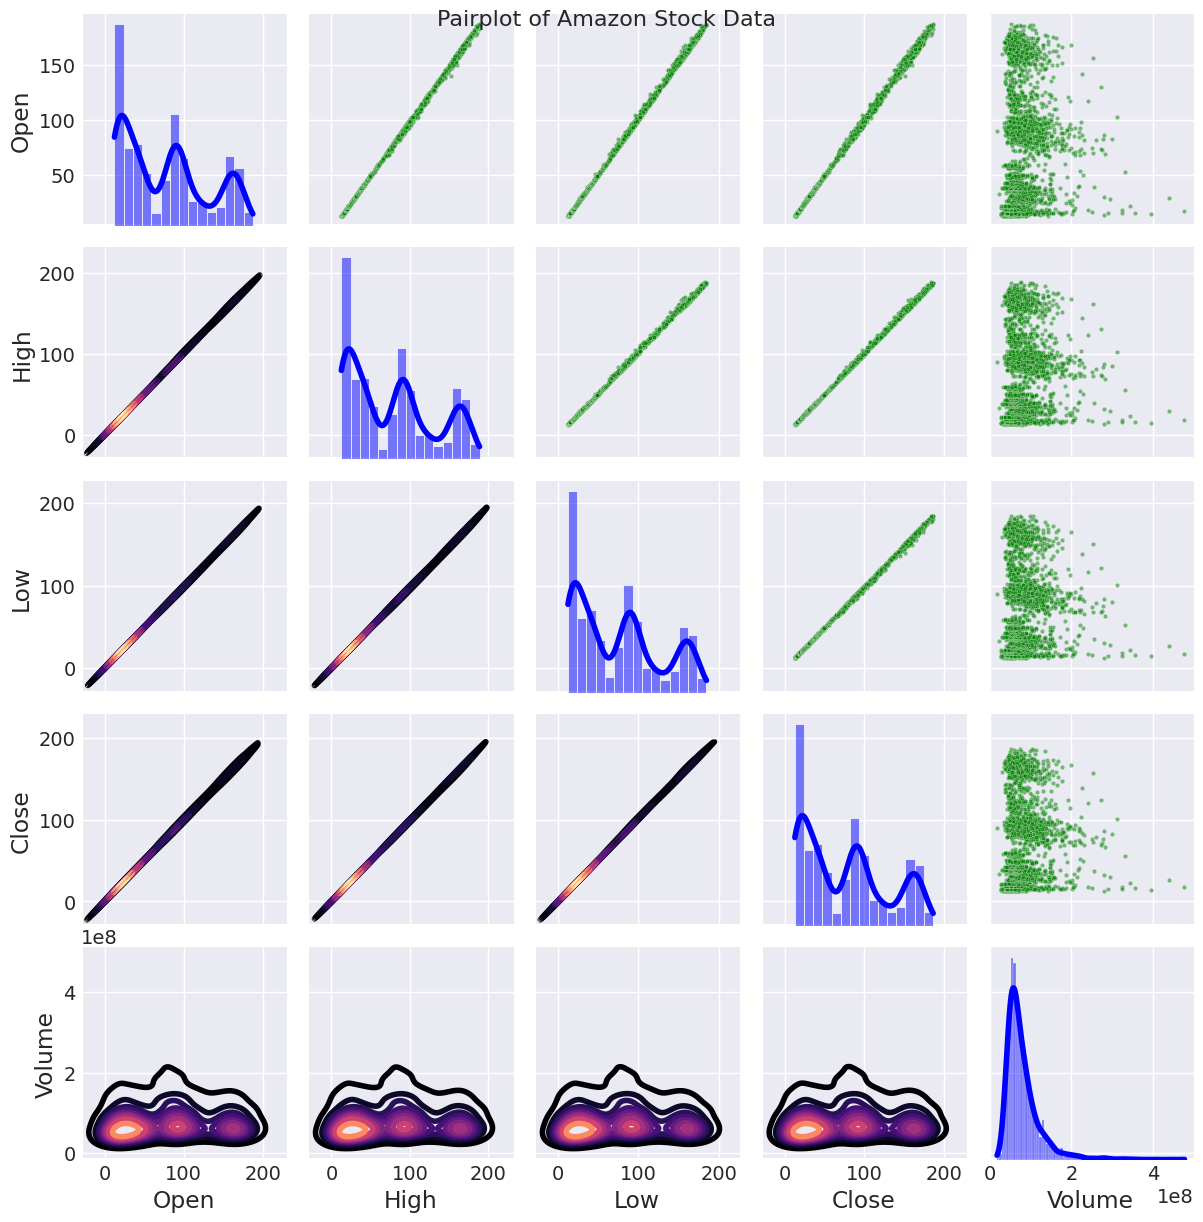

In [ ]:
features_AMZN = AMZN_data[["Open", "High", "Low", "Close", "Volume"]]
sns.set_palette("Set2")
sns.set_style("darkgrid")
g = sns.PairGrid(features_AMZN, diag_sharey=False)
g.map_upper(sns.scatterplot, s=10, alpha=0.5,color="green")
g.map_diag(sns.histplot, kde=True,color ='blue' )
g.map_lower(sns.kdeplot, cmap="magma", thresh=0.05)
plt.suptitle("Pairplot of Amazon Stock Data\n\n\n", fontsize=16)
legend_labels = ["Open", "High", "Low", "Close", "Volume"]
handles = [plt.plot([],[], marker="o", ls="", color=sns.color_palette()[i])[0] for i in range(len(legend_labels))]

g.fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

# 4. DATA PRE-PROCESSING 

# 4.1 Dropping outlier data/unrelated data(improve model perfomance)

In [ ]:
AMZN_data['Volume'].shape


(2518,)

In [ ]:
print(volume_outliers.min())
print(volume_outliers.max())

151964000
477122000


In [ ]:
AMZN_data[AMZN_data['Volume'] >151964000]

,Open,High,Low,Close,Volume,RSI
Date,,,,,,
2013-04-26,13.498500,13.601000,12.640500,12.740500,280600000,42.408773
2013-07-26,14.977500,15.681000,14.777500,15.600500,176350000,71.748613
2013-10-25,17.930000,18.420000,17.631001,18.169500,240736000,75.663990
2014-01-30,19.688499,20.312500,19.385000,20.150499,209478000,55.908883
2014-01-31,18.587999,18.772499,17.888000,17.934500,323096000,35.410124
...,...,...,...,...,...,...
2022-04-29,129.848999,130.761002,121.625000,124.281502,272662000,29.345901
2022-10-28,97.910004,103.959999,97.660004,103.410004,223133400,33.309477
2022-11-01,103.989998,104.580002,96.059998,96.790001,153370000,28.207111


In [ ]:
AMZN_data= AMZN_data.drop(AMZN_data[AMZN_data['Volume'] >151964000].index, axis = 0)

In [ ]:
AMZN_data.shape

(2381, 6)

In [ ]:
AMZN_data=AMZN_data.drop('RSI',axis=1)

# 4.2 Data Normalisation 

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(AMZN_data)
scaled_AMZN_data = pd.DataFrame(scaled_data, columns=AMZN_data.columns)

# 5. DATA MODELLING

# 5.1 Data Modelling-Keras (time series)

In [ ]:
look_back = 60
x_train = []
y_train = []
for i in range(look_back, len(scaled_data)):
    x_train.append(scaled_data[i-look_back:i, 0])
    y_train.append(scaled_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# 5.2 Model prediction

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor

def create_model(units=50, dropout=0.2, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# create KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=0)

# define the hyperparameter grid
param_grid = {
    'units': [32, 64, 128],
    'dropout': [0.1, 0.2, 0.3],
    'optimizer': ['adam', 'rmsprop']
}

<ipython-input-34-d21f7d530029>:16: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


In [ ]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

# define the scorer
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# perform the random search
random_search = RandomizedSearchCV(model, param_grid, n_iter=10, scoring=scorer, cv=3)
random_search.fit(x_train, y_train)

# print the best hyperparameters and score
print('Best hyperparameters:', random_search.best_params_)
print('Best score:', -random_search.best_score_)


ValueError: ignored

# 5.3 Model optimization 

# 6. MODEL SUMMARY 

# 6.1 Model outcome 

# 6.2 Project Summary/Conclusion

In [ ]:
.reset_index()
AMZN_data["Date"] = pd.to_datetime(AMZN_data["Date"])